In [1]:
import sys
import json
import warnings

import numpy as np
import scanpy as sc
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

sys.path.append('../..')
from utils import UnimapResult, set_plot_theme, generate_positions

set_plot_theme()
warnings.filterwarnings('ignore')

/home/hht/.conda/envs/unimap1/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### UMAP

In [2]:
s_data = sc.read_h5ad('../../data/pbmc9/pbmc9_s.h5ad')
t_data = sc.read_h5ad('../../data/pbmc9/pbmc9_t.h5ad')
s_data.obs["domain"] = "source"
t_data.obs["domain"] = "target"
raw_data = sc.concat([s_data, t_data], join="outer")
sc.tl.pca(raw_data, svd_solver="arpack")
sc.pp.neighbors(raw_data, n_neighbors=10, n_pcs=40)
sc.tl.umap(raw_data)

result = UnimapResult("pbmc9", f"unimap/2023", root_dir="../../results", detailed=False)

color_dict = json.load(open("../../color_dict.json"))
batch_c = color_dict["pbmc9_batch"]
ct_c = color_dict["pbmc9_ct"]

In [3]:
def generate_positions(w, h, l, b, x):
    position1 = [[l, b+2*h+2*x, w*2, h*2], [l+w*2+x, b+3*h+2*x, w, h], [l+w*3+x, b+3*h+2*x, w, h], [l+w*4+x, b+3*h+2*x, w, h], [l+w*5+x, b+3*h+2*x, w, h], [l+w*6+x, b+3*h+2*x, w, h],
                 [l+w*2+x, b+2*h+2*x, w, h], [l+w*3+x, b+2*h+2*x, w, h], [l+w*4+x, b+2*h+2*x, w, h], [l+w*5+x, b+2*h+2*x, w, h], [l+w*6+x, b+2*h+2*x, w, h]]

    position2 = [[l, b+0*h+0, w*2, h*2], [l+w*2+x, b+1*h+0, w, h], [l+w*3+x, b+1*h+0, w, h], [l+w*4+x, b+1*h+0, w, h], [l+w*5+x, b+1*h+0, w, h], [l+w*6+x, b+1*h+0, w, h],
                 [l+w*2+x, b+0*h+0, w, h], [l+w*3+x, b+0*h+0, w, h], [l+w*4+x, b+0*h+0, w, h], [l+w*5+x, b+0*h+0, w, h], [l+w*6+x, b+0*h+0, w, h]]

    return position1, position2

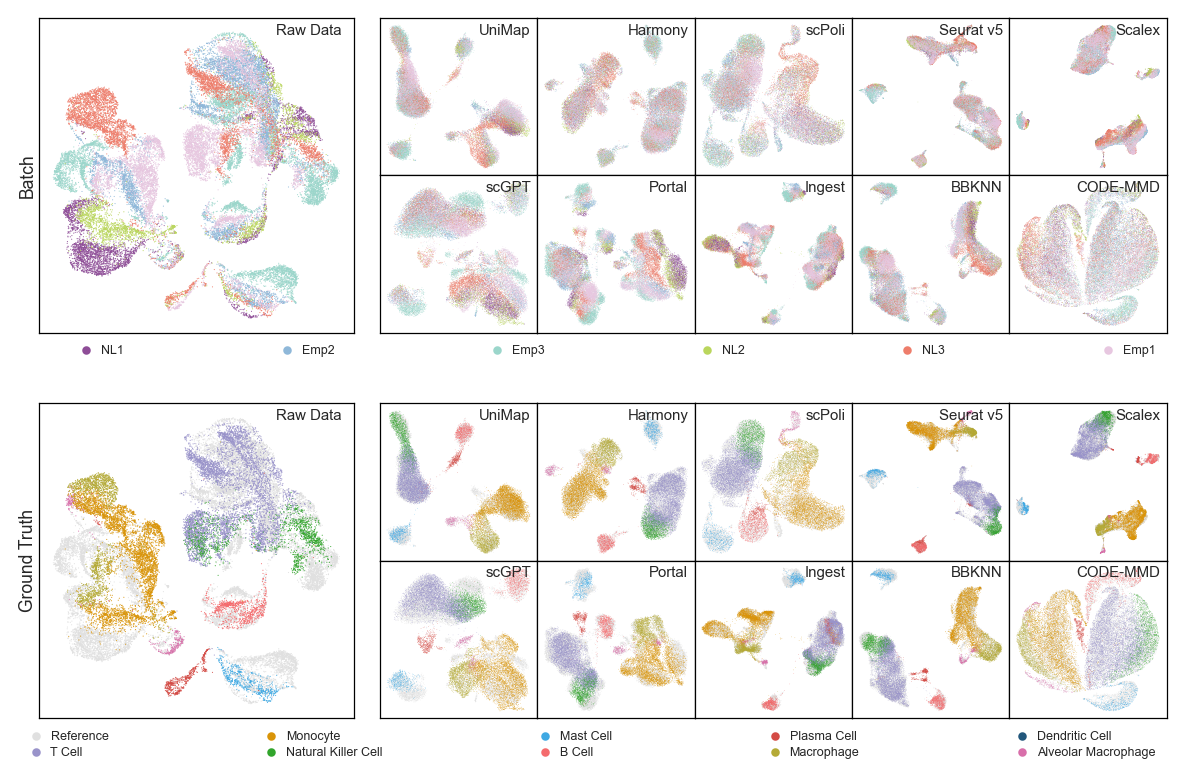

In [4]:
fig, axs = plt.subplots(figsize=(185 / 25.4, 250 / 25.4))
axs.remove()

models = ["raw_data"] + ["unimap", "harmony", "scpoli", "seurat", "scalex", "scgpt", "portal", "ingest", "bbknn", "code_mmd"]   # "code_adv"
models_name = ["Raw Data", "UniMap", "Harmony", "scPoli", "Seurat v5", "Scalex", "scGPT", "Portal", "Ingest", "BBKNN", "CODE-MMD"]  #  "CODE-ADV", 

w, h = 0.12, 0.12 / (250/185)
l, b, x = 0.04, 0.24, 0.02
position1, position2 = generate_positions(w, h, l, b, x)

for idx, model in enumerate(models):
    model_name = models_name[idx]
    if model == "raw_data":
        umap1 = raw_data.obsm["X_umap"][:, 0]
        umap2 = raw_data.obsm["X_umap"][:, 1]

        batch_labels = raw_data.obs["batch"]
        ct_labels_ref = ["reference"] * raw_data[raw_data.obs.domain == "source"].shape[0]
        ct_labels = ct_labels_ref + list(raw_data[raw_data.obs.domain == "target"].obs.celltype) 

    else:
        result = UnimapResult("pbmc9", f"{model}/2023", root_dir="../../results", detailed=False)
        umap1 = result.st_umap_result["umap1"]
        umap2 = result.st_umap_result["umap2"]

        batch_labels = result.st_result["batch"]
        ct_labels_ref = ["reference"] * result.st_result[result.st_result.domain == "source"].shape[0]
        ct_labels = ct_labels_ref + list(result.t_result[result.t_result.domain == "target"].celltype) 
    
    ax1 = fig.add_axes(position1[idx])
    ax2 = fig.add_axes(position2[idx])
    
    s = 0.2 if idx == 0 else 0.05
    p1 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=s, hue=batch_labels,    edgecolor="none", palette=batch_c, ax=ax1, rasterized=True)
    p2 = sns.scatterplot(x=umap1, y=umap2, alpha=0.9, s=s, hue=ct_labels,       edgecolor="none", palette=ct_c,    ax=ax2, rasterized=True)
    p1 = result.remove_ticks(p1, remove_legend=True)
    p2 = result.remove_ticks(p2, remove_legend=True)
    p1.set_ylabel("" if idx != 0 else "Batch",        fontsize=7, labelpad=1)
    p2.set_ylabel("" if idx != 0 else "Ground Truth", fontsize=7, labelpad=1)
    p1.text(0.96, (0.96 if idx == 0 else 0.92), model_name, ha="right", va="center", transform=p1.transAxes, fontsize=6)
    p2.text(0.96, (0.96 if idx == 0 else 0.92), model_name, ha="right", va="center", transform=p2.transAxes, fontsize=6)

    if idx == len(models) - 1:
        handles, labels = p1.get_legend_handles_labels()
        custom_handles = [mlines.Line2D([], [], color=color, marker="o", linestyle="None", markersize=0.2, label=label) for label, color in batch_c.items()]
        p1.legend(handles=custom_handles, loc="upper right", bbox_to_anchor=(1, -0.01), frameon=False, markerscale=12, fontsize=5, labelspacing=0.3, handletextpad=0.2, ncols=6,columnspacing=12,)
        
        handles, labels = p2.get_legend_handles_labels()
        custom_handles = [mlines.Line2D([], [], color=color, marker="o", linestyle='None', markersize=0.2, label=label.title()) for label, color in ct_c.items()]
        p2.legend(handles=custom_handles, loc='upper right', bbox_to_anchor=(1, -0.01), frameon=False, markerscale=12, fontsize=5, labelspacing=0.3, handletextpad=0.2, ncols=5, columnspacing=12)


In [5]:
w, h = 0.195, 0.195 / (250/185)

positions = [[0.040, 0.04, w, h],
             [0.255, 0.04, w, h],
             [0.49,  0.04, w, h],
             [0.705, 0.04, w, h]]

result = UnimapResult('pbmc9', 'unimap/2023', root_dir='../../results', detailed=False)
cell_w = result.t_result['pred_cell_prob']
ct_w = result.s_result['pred_celltype_prob'].rank(method='dense', ascending=False)

p2 = sns.scatterplot(x=result.t_umap_result['umap1'], y=result.t_umap_result['umap2'], alpha=0.9, s=0.2,
                     hue=result.t_result.pred_celltype,
                     edgecolor='none',
                     palette=ct_c,
                     ax=fig.add_axes(positions[2]), rasterized=True)

p3 = sns.scatterplot(x=result.t_umap_result['umap1'], y=result.t_umap_result['umap2'], alpha=0.9, s=0.2,
                     hue=cell_w,
                     edgecolor='none',
                     palette='inferno',
                     ax=fig.add_axes(positions[3]), rasterized=True)

p0 = sns.scatterplot(x=result.s_umap_result['umap1'], y=result.s_umap_result['umap2'], alpha=0.9, s=0.2,
                     hue=result.s_result.celltype,
                     edgecolor='none',
                     palette=ct_c,
                     ax=fig.add_axes(positions[0]), rasterized=True)

p1 = sns.scatterplot(x=result.s_umap_result['umap1'], y=result.s_umap_result['umap2'], alpha=0.9, s=0.2,
                     hue=ct_w,
                     edgecolor='none',
                     palette='inferno_r',
                     ax=fig.add_axes(positions[1]), rasterized=True)


p0 = result.remove_ticks(p0, remove_legend=True)
p1 = result.remove_ticks(p1, remove_legend=True)
p2 = result.remove_ticks(p2, remove_legend=True)
p3 = result.remove_ticks(p3, remove_legend=True)

p1.collections[0].set_cmap('inferno')
p2.collections[0].set_cmap('inferno_r')

p0.set_title('Reference',                     fontsize=7, pad=4)
p1.set_title('Reference Cell Weight Ranking', fontsize=7, pad=4)
p2.set_title('Query Predicted Result',        fontsize=7, pad=4)
p3.set_title('Query Cell Weight',             fontsize=7, pad=4)

p1.spines['top'].set_visible(False)
p1.spines['right'].set_visible(False)
p2.spines['top'].set_visible(False)
p2.spines['right'].set_visible(False)
p3.spines['top'].set_visible(False)
p3.spines['right'].set_visible(False)
p0.spines['top'].set_visible(False)
p0.spines['right'].set_visible(False)

cbar_ax1 = fig.add_axes([0.255+w*0.8, 0.04 + 0.005, w/25, h/4])  # [left, bottom, width, height]
norm1 = plt.Normalize(vmin=ct_w.min(), vmax=ct_w.max())
sm1 = plt.cm.ScalarMappable(cmap='inferno', norm=norm1)
cbar1 = fig.colorbar(sm1, cax=cbar_ax1, extend='both')
cbar1.set_ticks([1, 8])
cbar1.set_ticklabels(['low', 'high'])
cbar1.ax.tick_params(labelsize=5, length=1.5, pad=1, width=0.5)

cbar_ax2 = fig.add_axes([0.705+w*0.8, 0.04 + 0.005, w/25, h/4])  # [left, bottom, width, height]
norm2 = plt.Normalize(vmin=0, vmax=1)
sm2 = plt.cm.ScalarMappable(cmap='inferno', norm=norm2)
cbar2 = fig.colorbar(sm2, cax=cbar_ax2)
cbar2.set_ticks([0, 1])
cbar2.set_ticklabels(['0', '1'])
cbar2.ax.tick_params(labelsize=5, length=1.5, pad=1, width=0.5)


### RANKING

In [6]:
# raw_t_data = sc.read_h5ad('../../data/pbmc9/pbmc9_t.h5ad')
# unimap_result = UnimapResult('pbmc9', 'unimap/2023', root_dir='../../results')
# models = ['unimap', 'harmony', 'seurat', 'code_adv', 'code_mmd', 'bbknn',  'scalex', 'portal', 'scpoli', 'ingest', 'scgpt']

# eval_results = pd.DataFrame()
# for model in models:
#     result = UnimapResult('pbmc9', f'{model}/2023', root_dir='../../results', detailed=False) 
#     eval_result = result.get_evaluation_index()
#     eval_results = pd.concat([eval_results, eval_result], axis=0)
# eval_results.to_csv('results/pbmc9_eval_results.csv')

In [7]:
# * eval results
eval_results = pd.read_csv("results/pbmc9_eval_results.csv", index_col=0) 
eval_results.index = eval_results.index.map(lambda x: x.split('/')[0])
models = ['unimap', 'harmony', 'scpoli', 'seurat', 'scalex', 'scgpt', 'portal', 'ingest', 'bbknn', 'code_mmd', 'code_adv']  # code_mmd
eval_results = eval_results.reindex(models)


# * index
index_list = ['ari', 'isolated_labels_f1', 'clisi_graph', 'isolated_labels_asw', 'nmi', 'silhouette', 'overcorrection_score', 'acc', 'ilisi_graph', 'silhouette_batch', 'kBET', 'graph_connectivity'] 
index_list_bio = ['ari', 'isolated_labels_f1', 'clisi_graph', 'isolated_labels_asw', 'nmi', 'silhouette', 'overcorrection_score', 'acc', ]
index_list_batch = ['ilisi_graph', 'silhouette_batch', 'kBET', 'graph_connectivity']


# * All
eval_results = eval_results.loc[:, index_list]
eval_results_long = eval_results.melt(ignore_index=False).reset_index()
eval_results_long = eval_results_long.rename(columns={'index': 'model'})
eval_results_long['rank'] = eval_results_long.groupby('variable')['value'].rank(ascending=False)
eval_results_long_mean = eval_results_long.groupby('model').agg({'value': 'mean'}).reset_index()
eval_results_long_mean['rank'] = eval_results_long_mean['value'].rank(ascending=False)
eval_results_long_mean.index = eval_results_long_mean.model
eval_results_long_mean = eval_results_long_mean.loc[models, :]

# * Bio
eval_results_bio = eval_results.loc[:, index_list_bio]
eval_results_long_bio = eval_results_bio.melt(ignore_index=False).reset_index()
eval_results_long_bio = eval_results_long_bio.rename(columns={'index': 'model'})
eval_results_long_bio['rank'] = eval_results_long_bio.groupby('variable')['value'].rank(ascending=False)
eval_results_long_mean_bio = eval_results_long_bio.groupby('model').agg({'value': 'mean'}).reset_index()
eval_results_long_mean_bio['rank'] = eval_results_long_mean_bio['value'].rank(ascending=False)
eval_results_long_mean_bio.index = eval_results_long_mean_bio.model
eval_results_long_mean_bio = eval_results_long_mean_bio.loc[models, :]

# * Batch
eval_results_batch = eval_results.loc[:, index_list_batch]
eval_results_long_batch = eval_results_batch.melt(ignore_index=False).reset_index()
eval_results_long_batch = eval_results_long_batch.rename(columns={'index': 'model'})
eval_results_long_batch['rank'] = eval_results_long_batch.groupby('variable')['value'].rank(ascending=False)
eval_results_long_mean_batch = eval_results_long_batch.groupby('model').agg({'value': 'mean'}).reset_index()
eval_results_long_mean_batch['rank'] = eval_results_long_mean_batch['value'].rank(ascending=False)
eval_results_long_mean_batch.index = eval_results_long_mean_batch.model
eval_results_long_mean_batch = eval_results_long_mean_batch.loc[models, :]

In [8]:
cmap1 = sns.color_palette("blend:" + '#FFF6F2' + "," + '#EE7F6D', n_colors=11)
cmap2 = sns.color_palette("Oranges", 16)[::1]  
cmap3 = sns.color_palette("BuPu", 16)[::1]

def set_theme(ax, xlim, metrics_list, model_list, one_tick=False, rotation=30, ha='right', fontweight='regular', fontsize=7):
    if ax.get_legend():
        ax.get_legend().remove()
    ax.set(xlabel=None, ylabel=None)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_xlim(xlim)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks(np.arange(len(metrics_list)))
    if one_tick != False:
        ax.set_xticks([one_tick])
    ax.set_xticklabels(metrics_list, rotation=rotation, ha=ha, fontweight=fontweight, fontsize=fontsize)
    ax.set_yticklabels(model_list, fontsize=fontsize)
    ax.tick_params(width=0.5, length=3)
    for patch in ax.patches:
        patch.set_linewidth(0.5)

In [9]:
xlim = [-1, 21]
w, h = 0.64, 0.28 / (250/185)
ax1 = fig.add_axes([0.14, 0.74, w, h])

ax1 = sns.scatterplot(x="variable", y="model", hue="rank", size="value", sizes=(10, 150), alpha=1,  palette=cmap1, edgecolor='black', data=eval_results_long_bio, ax=ax1, linewidths=0.5)
set_theme(ax1, xlim=xlim, metrics_list=['ARI', 'Isolated Label F1', 'Graph cLISI', ' Label ASW', 'NMI', 'ASW', 'Over-correction score', 'Accuracy', ], model_list=['UniMap', 'Harmony', 'scPoli', 'Seurat v5', 'Scalex', 'scGPT', 'Portal', 'Ingest', 'BBKNN', 'CODE-MMD', 'CODE-ADV'])

ax2 = ax1.twiny()
ax2 = sns.barplot(x=eval_results_long_mean_bio['value'] * 2, y=models, palette=[cmap1[i] for i in eval_results_long_mean_bio['rank'].astype(int) - 1], edgecolor='black', ax=ax2, legend=True, )
ax2.axvline(x=0, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))
ax2.axvline(x=2, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))
set_theme(ax2, xlim=[i - 8 for i in xlim], metrics_list=['Biological conservation'], model_list=models, one_tick=eval_results_long_mean_bio['value'].max(), fontweight='bold')
# 字体加粗
ax2.set_yticklabels(ax2.get_yticklabels(), fontweight='bold')

ax22 = ax1.twiny()
set_theme(ax22, xlim=[i - 8 for i in xlim], metrics_list=['bio_rank'], model_list=models, one_tick=eval_results_long_mean_bio['value'].max(), rotation=0, ha='center')
ax22.set_xticks([0,1, 2])
ax22.set_xticklabels(['0', '0.5', '1'], fontsize=5)
ax22.xaxis.tick_top()

ax3 = ax1.twiny()
ax3 = sns.scatterplot(x="variable", y="model", hue="rank", size="value", sizes=(10, 150), alpha=1, palette=cmap2, edgecolor='black', data=eval_results_long_batch, ax=ax3, linewidths=0.5)
set_theme(ax3, xlim=[i - 11 for i in xlim], metrics_list=['Graph iLISI', 'Batch ASW', 'kBET', 'GC'], model_list=models)


ax4 = ax1.twiny()
ax4 = sns.barplot(x=eval_results_long_mean_batch['value'] * 2, y=models, palette=[cmap2[i] for i in eval_results_long_mean_batch['rank'].astype(int) - 1], edgecolor='black', ax=ax4, legend=True)
set_theme(ax4, xlim=[i - 15 for i in xlim], metrics_list=['Batch correction'], model_list=models, one_tick=eval_results_long_mean_batch['value'].max(), fontweight='bold')
ax4.axvline(x=0, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))
ax4.axvline(x=2, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))

ax44 = ax1.twiny()
set_theme(ax44, xlim=[i - 15 for i in xlim], metrics_list=['bio_rank'], model_list=models, one_tick=eval_results_long_mean_batch['value'].max(), rotation=0, ha='center')
ax44.set_xticks([0,1, 2])
ax44.set_xticklabels(['0', '0.5', '1'], fontsize=5)
ax44.xaxis.tick_top()

ax5 = ax1.twiny()
ax5 = sns.barplot(x=eval_results_long_mean['value'].values  * 2, y=models, palette=[cmap3[i] for i in eval_results_long_mean['rank'].astype(int) - 1], edgecolor='black', ax=ax5, legend=True)
set_theme(ax5, xlim=[i - 17.5 for i in xlim], metrics_list=['Overrall score'], model_list=models, one_tick=eval_results_long_mean['value'].max(), fontweight='bold')
ax5.axvline(x=0, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))
ax5.axvline(x=2, linestyle='--', color='black', linewidth=0.5, dashes=(7, 3))

ax55 = ax1.twiny()
set_theme(ax55, xlim=[i - 17.5 for i in xlim], metrics_list=['bio_rank'], model_list=['UniMap', 'Harmony', 'scPoli', 'Seurat v5', 'Scalex', 'scGPT', 'Portal', 'Ingest', 'BBKNN', 'CODE-MMD', 'CODE-ADV'], one_tick=eval_results_long_mean['value'].max(), rotation=0, ha='center')
ax55.set_xticks([0,1, 2])
ax55.set_xticklabels(['0', '0.5', '1'], fontsize=5)
ax55.xaxis.tick_top()

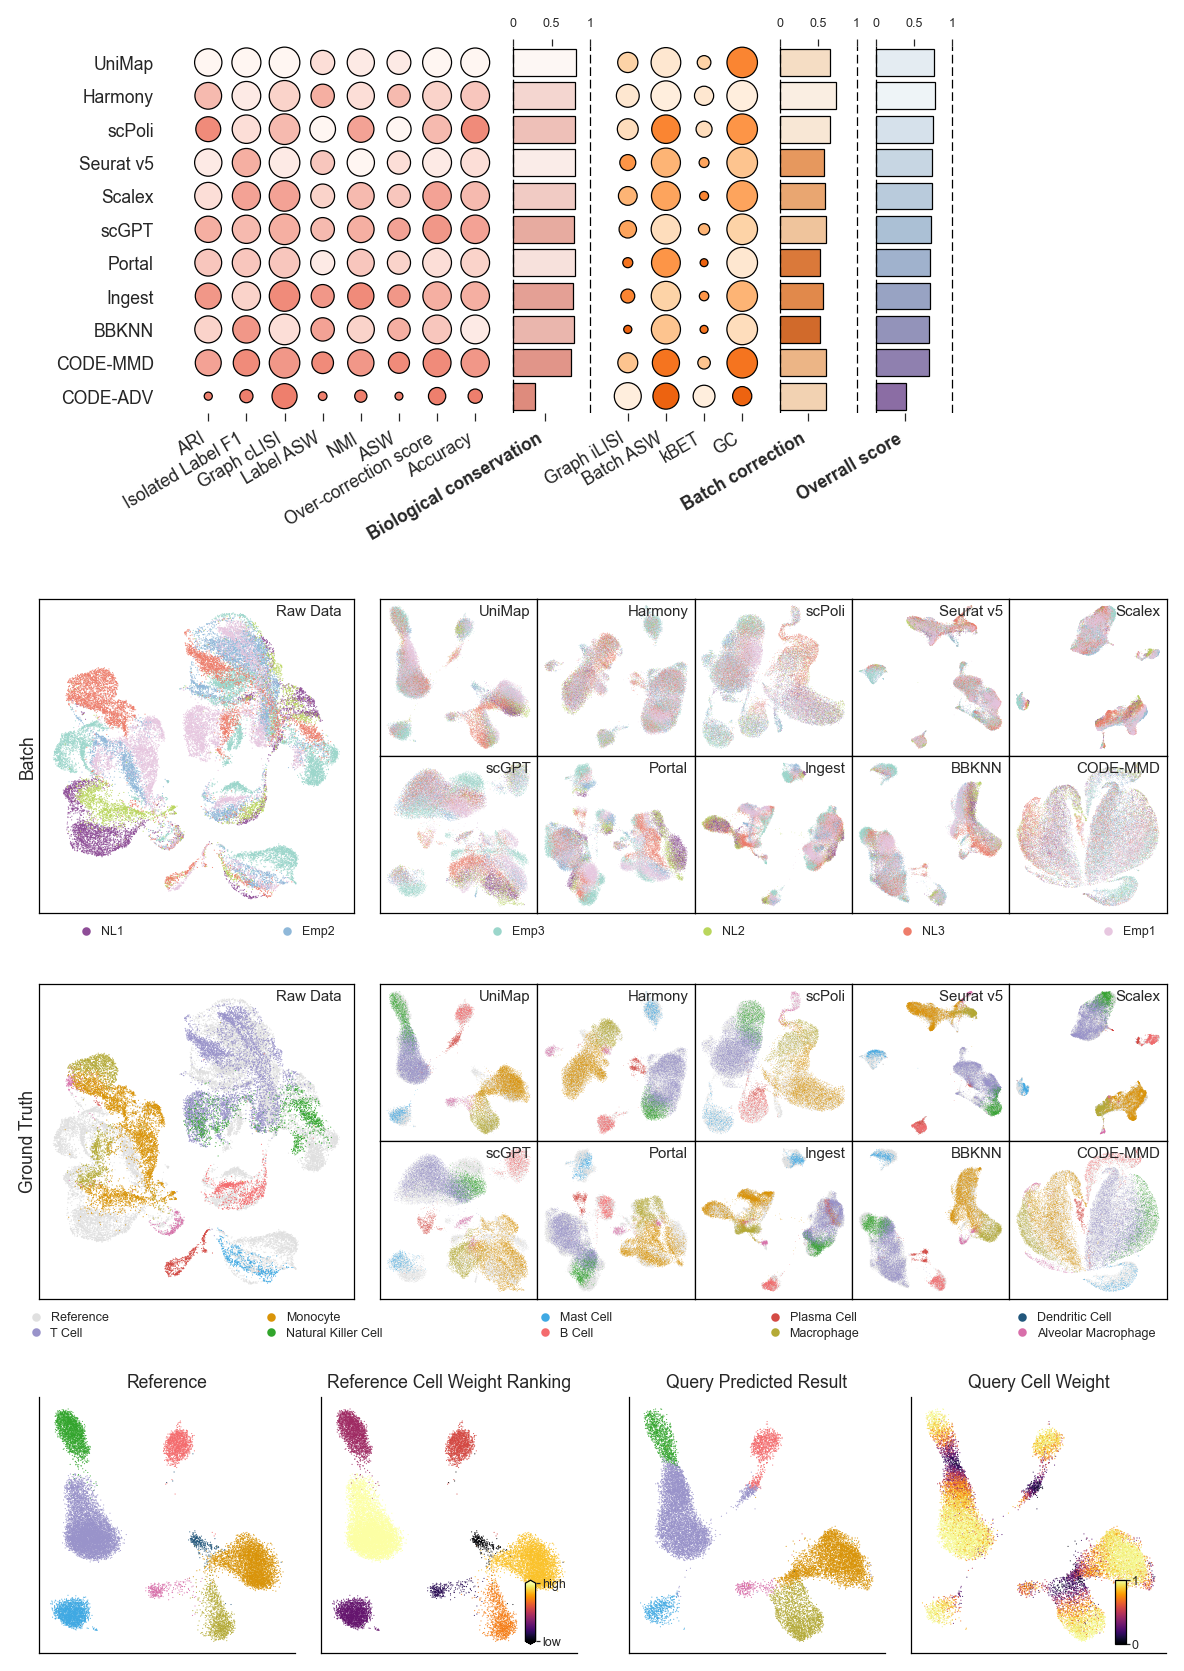

In [10]:
fig

In [11]:
# fig.savefig('../figs/fig2.pdf', dpi=720)